In [1]:
import numpy as np
import sys
sys.path.append("..")
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys

from missing_process.block_rules import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tqdm import tqdm


In [142]:
real_datalist = ["banknote","concrete_compression",
            # "wine_quality_white","wine_quality_red",
            # "california","climate_model_crashes",
            # "connectionist_bench_sonar","qsar_biodegradation",
            # "yeast","yacht_hydrodynamics"
            ]
#real_datalist = ["yacht_hydrodynamics"]

syn_datalist = ["syn1"]
real_datalist = ["banknote"]

#missingtypelist = ["quantile","diffuse","logistic"]
missingtypelist = ["logistic"]

seed = 1
nfold = 5



In [3]:
def load_origin_data(missingtypelist,datalist_name):
    '''
    create density plot
    '''
    

    if datalist_name == "real":
        datalist = real_datalist
    elif datalist_name == "syn":
        datalist = syn_datalist

    for missingtype in missingtypelist:
        if missingtype == "logistic":
            missing_rule = load_json_file("missing_rate.json")
        elif missingtype == "diffuse":
            missing_rule = load_json_file("diffuse_ratio.json")
        elif missingtype == "quantile":
            missing_rule = load_json_file("quantile_full.json")

        # load data and its mask
        for dataname in datalist:
            directory_path = f"../datasets/{dataname}"    
            norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
            
            print(dataname)


            for rule_name in missing_rule:
                observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')


            return norm_values,observed_masks

In [128]:
def RMSE(mask,complete,imputed):
    missing_data_points = mask == 0

    # Extracting the originally missing data from both complete and imputed data
    original_values = complete[missing_data_points]
    imputed_values = imputed[missing_data_points]

    # Calculating RMSE
    rmse = np.sqrt(np.mean((original_values - imputed_values) ** 2))

    return rmse

def complete_computed_value(mask, complete, imputed):
    # Create an empty array with the same shape as 'complete' and 'imputed'
    computed = np.empty_like(complete)

    # Fill in the values
    computed[mask == 1] = complete[mask == 1]  # Use values from 'complete' where mask is 1
    computed[mask == 0] = imputed[mask == 0]   # Use values from 'imputed' where mask is 0

    return computed

def complete_computed_value(mask, complete, imputed):
    # Create an array filled with 'nan' with the same shape as 'complete' and 'imputed'
    computed = np.full_like(complete, np.nan, dtype=float)

    # Fill in the imputed values where mask is 0
    computed[mask == 0] = imputed[mask == 0]

    return computed

# Example usage
# mask, complete, and imputed should be numpy arrays of the same shape
# complete_computed = complete_computed_value(mask, complete, imputed)


def MAE(mask,complete,imputed):
    missing_data_points = mask == 0

    # Extracting the originally missing data from both complete and imputed data
    original_values = complete[missing_data_points]
    imputed_values = imputed[missing_data_points]

    # Calculating RMSE
    mae = np.mean(np.abs(original_values - imputed_values))

    return mae

In [5]:
def load_impute_data(missingtype,model_name,rule_name,dataname,fold,seed = 1):

    train_impute = np.load(f'../impute/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_train.npy')
    test_impute = np.load(f'../impute/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_test.npy')
    return train_impute,test_impute

def load_train_test(index_file,norm_values,observed_masks):  

    train_index = index_file["train_index"]
    test_index = index_file["test_index"]

    train_values = norm_values[train_index,:]

    train_masks = observed_masks[train_index,:]

    test_values = norm_values[test_index,:]

    test_masks = observed_masks[test_index,:]

    return train_values,train_masks,test_values,test_masks

In [175]:
datalist = real_datalist
#datalist = syn_datalist
model_name = "ot"
plot = True

missingtypelist = ["logistic"]


for missingtype in missingtypelist:
    if missingtype == "logistic":
        missing_rule = load_json_file("missing_rate.json")
    elif missingtype == "diffuse":
        missing_rule = load_json_file("diffuse_ratio.json")
    elif missingtype == "quantile":
        missing_rule = load_json_file("quantile_full.json")

    # load data and its mask
    for dataname in tqdm(datalist):
        directory_path = f"../datasets/{dataname}"    
        norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
        f = open(f'{directory_path}/split_index_cv_seed-{seed}_nfold-{nfold}.json')
        index_file = json.load(f)
        print(dataname)

        train_rmse_mean = []
        train_rmse_std = []
        train_mae_mean = []
        train_mae_std = []

        
        test_rmse_mean = []
        test_rmse_std = []
        test_mae_mean = []
        test_mae_std = []


        for rule_name in tqdm(missing_rule):
            observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')
            train_rmse_list = []
            train_mae_list = []
            test_rmse_list = []
            test_mae_list = []
            for fold in index_file:
                index = index_file[fold]
                train_values,train_masks,test_values,test_masks = load_train_test(index,norm_values,observed_masks)
                impute_train,impute_test  = load_impute_data(missingtype,model_name,rule_name,dataname,fold)

                train_rmse = RMSE(train_masks,train_values,impute_train)
                train_mae = MAE(train_masks,train_values,impute_train)

                test_rmse = RMSE(test_masks,test_values,impute_test)
                test_mae = MAE(test_masks,test_values,impute_test)

                train_rmse_list.append(train_rmse)
                train_mae_list.append(train_mae)
                test_rmse_list.append(test_rmse)
                test_mae_list.append(test_mae)
            
            if train_rmse > 0.3 and plot:
                print(rule_name)
                rmse = RMSE_columnwise(train_masks,train_values,impute_train)
                print(rmse)
                make_line_plot(train_values,impute_train,train_masks,title = f"{model_name} {dataname} {missingtype} {rule_name}",subtitle=rmse)
            
                

            train_rmse_mean.append(np.mean(train_rmse_list))
            train_rmse_std.append(np.std(train_rmse_list))

            train_mae_mean.append(np.mean(train_mae_list))
            train_mae_std.append(np.std(train_mae_list))

            test_rmse_mean.append(np.mean(test_rmse_list))
            test_rmse_std.append(np.std(test_rmse_list))

            test_mae_mean.append(np.mean(test_mae_list))
            test_mae_std.append(np.std(test_mae_list))


        df = pd.DataFrame({
        "train_rmse_mean": train_rmse_mean,
        "train_rmse_std":train_rmse_std,

        "train_mae_mean": train_mae_mean,
        "train_mae_std": train_mae_std,

        "test_rmse_mean": test_rmse_mean,
        "test_rmse_std": test_rmse_std,

        "test_mae_mean": test_mae_mean,
        "test_mae_std": test_mae_std
    },index = [rule_name for rule_name in missing_rule])
        
        path = f"../results/{missingtype}/{dataname}/{model_name}"
        if not os.path.exists(path):
            # If the path does not exist, create it
            os.makedirs(path)
        
        df.to_csv(f'{path}/{missingtype}_RMSE.csv')
            
        


  0%|          | 0/1 [00:00<?, ?it/s]

banknote


  0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '../impute/logistic/banknote/ot/0.1_seed-1_fold_1_train.npy'

In [130]:
def RMSE_columnwise(mask, complete, imputed):


    # Initializing an array to store RMSE for each column
    rmse_per_column = np.zeros(complete.shape[1])

    # Iterate over each column
    for i in range(complete.shape[1]):
        missing_data_points = mask[:, i] == 0
        # Extracting the originally missing data from both complete and imputed data
        original_values = complete[missing_data_points, i]
        imputed_values = imputed[missing_data_points, i]

        # Calculating RMSE for this column
        rmse_per_column[i] = np.sqrt(np.mean((original_values - imputed_values) ** 2))

    return np.nan_to_num(rmse_per_column, nan=0)

In [153]:
def make_plot(norm_value,impute,mask, title = None,subtitle = None):

    indices = np.argsort(subtitle)[-8:]

    # Sorting the indices and converting to a list
    sorted_indices = np.sort(indices).tolist()

        # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    axes = axes.ravel()  # Flatten the 4x2 grid for easy iteration

    impute_value = impute
    nan_mask = np.where(mask == 0, np.nan, mask)
    masked_value_na = norm_value * nan_mask
    
    

    for i in range(len(sorted_indices)):
        norm_column = norm_value[:, sorted_indices[i]]
        impute_column = impute_value[:, sorted_indices[i]]
        mask_column_na = masked_value_na[:, sorted_indices[i]]

        
        bins = np.histogram_bin_edges([norm_column, impute_column], bins='auto')
        #data_column2 = array_list[1][i]
        # Histogram
        #axes[i].hist(data_column, bins=30, alpha=0.7, edgecolor='black',kde = True)
        sns.histplot(data=norm_column, bins=bins, color='orange',alpha = 0.4, ax=axes[i], kde=True, label='Complete Data',
                     #hatch="", 
                     fill=False
                     )
        sns.histplot(data=mask_column_na, bins=bins, color='blue',alpha = 0.1, ax=axes[i], kde=True, label='Observed Data',
                     #hatch="/", 
                     #fill=False
                     )
        sns.histplot(data=impute_column, bins=bins, color='green',alpha = 0.6, ax=axes[i], kde=True, label='Imputed Data',
                     hatch='...', 
                     fill=False
                     )
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        if subtitle[i]:
            axes[i].set_title(f'Histogram for Column {sorted_indices[i]+1} RMSE: {subtitle[i]}')
        else:
            axes[i].set_title(f'Histogram for Column {sorted_indices[i]+1}')
        axes[i].legend()

    if title is not None:
        fig.suptitle(title, fontsize=16)
        # Adjust the layout
    plt.tight_layout()
    plt.savefig(f"../plot/{title}_histo.png")
    plt.show()

In [164]:
def make_line_plot(norm_value,impute,mask, title = None,subtitle = None):

    indices = np.argsort(subtitle)[-8:]

    # Sorting the indices and converting to a list
    sorted_indices = np.sort(indices).tolist()

        # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    axes = axes.ravel()  # Flatten the 4x2 grid for easy iteration

    impute_value = complete_computed_value(mask, norm_value, impute)
    true_value = complete_computed_value(mask, norm_value, norm_value)
    nan_mask = np.where(mask == 0, np.nan, mask)
    masked_value_na = norm_value * nan_mask
    
    

    for i in range(len(sorted_indices)):
        norm_column = norm_value[:, sorted_indices[i]]
        impute_column = impute_value[:, sorted_indices[i]]
        mask_column_na = masked_value_na[:, sorted_indices[i]]
        true_column = true_value[:, sorted_indices[i]]
        # Sorting based on norm_column
        sorted_index = np.argsort(norm_column)
        norm_column_sorted = norm_column[sorted_index]
        impute_column_sorted = impute_column[sorted_index]
        mask_column_na_sorted = mask_column_na[sorted_index]
        true_column_sorted = true_column[sorted_index]

        # axes[i].scatter(range(len(norm_column_sorted)), norm_column_sorted, label='Complete Data', color="orange", alpha=1, s=50, marker='s')  # Circle marker
        axes[i].scatter(range(len(mask_column_na_sorted)), mask_column_na_sorted, label='Observed Data', color='blue', alpha=1, s=10, marker='s')  # Square marker
        axes[i].scatter(range(len(impute_column_sorted)), impute_column_sorted, label='Imputed Data', color='red', alpha=0.5, s=10, marker='o')  # Triangle marker
        axes[i].scatter(range(len(true_column_sorted)), true_column_sorted, label='Unobserved Data', color='orange', alpha=0.7, s=1, marker='x')  # Triangle marker
            # sns.histplot(data=impute_column, color='green',alpha = 0.6, ax=axes[i], kde=True, label='Imputed Data',
        #              hatch='...', 
        #              fill=False
        #              )

        #axes[i].set_ylim(-1, 1)
        #axes[i].set_xlabel('Index')
        axes[i].set_xticks([])
        axes[i].set_ylabel('Value')
        
        if subtitle[i]:
            axes[i].set_title(f'Histogram for Column {sorted_indices[i]+1} RMSE: {subtitle[i]}')
        else:
            axes[i].set_title(f'Histogram for Column {sorted_indices[i]+1}')
        axes[i].legend()

    if title is not None:
        fig.suptitle(title, fontsize=16)
        # Adjust the layout
    plt.tight_layout()
    plt.savefig(f"../plot/{title}_scatter.png")
    plt.show()

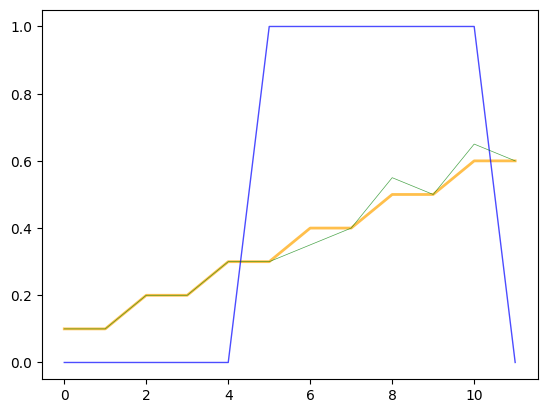

In [23]:
mask = np.array([1,1,1,0,0,0,1,1,0,0,0,1])
complete = np.array([0.4, 0.5, 0.6,0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.1, 0.2, 0.3])
imputed = np.array([0.35, 0.55, 0.65,0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.1, 0.2, 0.3])

sorted_index = np.argsort(complete)
norm_column_sorted = complete[sorted_index]
impute_column_sorted = imputed[sorted_index]
mask_column_na_sorted = mask[sorted_index]


# norm_column_sorted = complete
# impute_column_sorted = imputed
# mask_column_na_sorted = mask


# Line plot
plt.plot(norm_column_sorted, label='Complete Data', color='orange', linewidth=2, alpha=0.7)
plt.plot(mask_column_na_sorted, label='Observed Data', color='blue', linewidth=1, alpha=0.7)
plt.plot(impute_column_sorted, label='Imputed Data', color='green', linewidth=0.5, alpha=0.7)


In [57]:
array = np.array([0.52868909, 0.50881588, 0.52073359, 0.53296602, 0.52735263, 
                  np.nan])

np.nan_to_num(array, nan=0)
# Ignoring np.nan and finding the indices of the largest 8 numbers
indices = np.argsort(array)[-3:]

# Sorting the indices and converting to a list
sorted_indices = np.sort(indices).tolist()
sorted_indices

sorted_indices

[0, 3, 5]